# MAFFT Example

Before running we need to install MAFFT and a wrapper for it in Python. First, install MAFFT:
> [MAFFT installation instructions](https://mafft.cbrc.jp/alignment/software/)

Then you want to install BioPython (which has a wrapper for MAFFT). If using Anaconda run:
> conda install biopython

In [1]:
from Bio.Align.Applications import MafftCommandline
from io import StringIO
from Bio import AlignIO
import numpy as np
import jax.numpy as jnp
import jax
import jaxlib
import pickle
import matplotlib.pyplot as plt

In [2]:
def MAFFT(in_file):
    mafft_cline = MafftCommandline(input=in_file,localpair=True)
    # the above requires using command line
    # output to a python datatype
    stdout, stderr = mafft_cline()
    return AlignIO.read(StringIO(stdout), "fasta")

In [3]:
# Create alignment
in_file = "ex.fasta"
align = MAFFT(in_file)

# print resulting alignment
for element in align:
    print(element.seq)
# alt print(align)

---act
gata--
--tag-
--tac-


# Alignment Scoring

Compute sum-of-pairs-like scores. First, scoring based on BLOSUM for protein sequences (the following code is from Petti et al.: [make_pairwise_aln_figures.ipynb](https://github.com/spetti/SMURF/blob/main/examples/LAM_AF_examples/make_pairwise_aln_figures.ipynb))

In [4]:
# BLOSUM62 from https://www.ncbi.nlm.nih.gov/IEB/ToolBox/C_DOC/lxr/source/data/BLOSUM62   
array_as_str = "4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1 -1 -1 -4"\
" -1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1 -2  0 -1 -4"\
" -2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  4 -3  0 -1 -4"\
" -2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4 -3  1 -1 -4"\
" 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -1 -3 -1 -4"\
" -1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0 -2  4 -1 -4"\
" -1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1 -3  4 -1 -4"\
" 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -4 -2 -1 -4"\
" -2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0 -3  0 -1 -4"\
" -1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3  3 -3 -1 -4"\
" -1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4  3 -3 -1 -4"\
" -1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0 -3  1 -1 -4"\
" -1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3  2 -1 -1 -4"\
" -2 -3 -3 -3 -2 -3 -3 -3 -1  0  0 -3  0  6 -4 -2 -2  1  3 -1 -3  0 -3 -1 -4"\
" -1 -2 -2 -1 -3 -1 -1 -2 -2 -3 -3 -1 -2 -4  7 -1 -1 -4 -3 -2 -2 -3 -1 -1 -4"\
" 1 -1  1  0 -1  0  0  0 -1 -2 -2  0 -1 -2 -1  4  1 -3 -2 -2  0 -2  0 -1 -4"\
" 0 -1  0 -1 -1 -1 -1 -2 -2 -1 -1 -1 -1 -2 -1  1  5 -2 -2  0 -1 -1 -1 -1 -4"\
" -3 -3 -4 -4 -2 -2 -3 -2 -2 -3 -2 -3 -1  1 -4 -3 -2 11  2 -3 -4 -2 -2 -1 -4"\
" -2 -2 -2 -3 -2 -1 -2 -3  2 -1 -1 -2 -1  3 -3 -2 -2  2  7 -1 -3 -1 -2 -1 -4"\
" 0 -3 -3 -3 -1 -2 -2 -3 -3  3  1 -2  1 -1 -2 -2  0 -3 -1  4 -3  2 -2 -1 -4"\
" -2 -1  4  4 -3  0  1 -1  0 -3 -4  0 -3 -3 -2  0 -1 -4 -3 -3  4 -3  0 -1 -4"\
" -1 -2 -3 -3 -1 -2 -3 -4 -3  3  3 -3  2  0 -3 -2 -1 -2 -1  2 -3  3 -3 -1 -4"\
" -1  0  0  1 -3  4  4 -2  0 -3 -3  1 -1 -3 -1  0 -1 -2 -2 -2  0 -3  4 -1 -4"\
" -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -4"\
" -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4 -4  1"\

# make this into a matrix
BLOSUM_array=np.array([int(_) for _ in array_as_str.split(" ") if _ !='']).reshape((25,25))

# as a dictionary to make it easy w/ inputs
aa_s=[_ for _ in "A  R  N  D  C  Q  E  G  H  I  L  K  M  F  P  S  T  W  Y  V  B  J  Z  X  *".split(" ") if _ !='']
BLOSUM_d={}
for n1, aa1 in enumerate(aa_s):
    for n2, aa2 in enumerate(aa_s):
         BLOSUM_d[(aa1, aa2)]=BLOSUM_array[n1,n2]
            
# unit gap penalty
for aa in aa_s:
    BLOSUM_d[(aa,"-")] = -1
    BLOSUM_d[("-",aa)] = -1
BLOSUM_d[("-","-")] = 0

def count_gap_prefix(seq):
    gap_count = 0
    for ch in seq:
        if type(ch) == int and ch <0: gap_count +=1
        elif ch == '-': gap_count +=1
        else: return gap_count
    return gap_count

# get pairwise
def get_blosum_score(seq1, seq2):
    start = min(count_gap_prefix(seq1), count_gap_prefix(seq2))
    end = min(count_gap_prefix(seq1[::-1]), count_gap_prefix(seq2[::-1]))
    score = 0
    for n in range(start, len(seq1)- end):
        score += BLOSUM_d[(seq1[n], seq2[n])]
    return score

# if aligned appropriately +1 else -1
def get_unit_score(seq1, seq2):
    start = min(count_gap_prefix(seq1), count_gap_prefix(seq2))
    end = min(count_gap_prefix(seq1[::-1]), count_gap_prefix(seq2[::-1]))
    score = 0
    for n in range(start, len(seq1)- end):
        if seq1[n] == seq2[n]:
            score += 1
        else:
            score -= 1
    return score

In [5]:
# get each pairwise BLOSUM score for each value in example FASTA file
# while the ex uses DNA the letters are accounted for in the BLOSUM mat
seqs = len(align)
for i in range(seqs):
    for j in range(i+1,seqs):
        seq1 = align[i].seq.upper()
        seq2 = align[j].seq.upper()
        blosum = get_blosum_score(seq1, seq2)
        unit = get_unit_score(seq1, seq2)
        print("BLOSUM score of " + str(seq1.strip('-')) + ' to ' + str(seq2.strip('-')) + ': ' + str(blosum))
        print("Unit score of " + str(seq1.strip('-')) + ' to ' + str(seq2.strip('-')) + ': ' + str(unit))

BLOSUM score of ACT to GATA: -1
Unit score of ACT to GATA: -4
BLOSUM score of ACT to TAG: -1
Unit score of ACT to TAG: -2
BLOSUM score of ACT to TAC: 11
Unit score of ACT to TAC: 0
BLOSUM score of GATA to TAG: 6
Unit score of GATA to TAG: -1
BLOSUM score of GATA to TAC: 6
Unit score of GATA to TAC: -1
BLOSUM score of TAG to TAC: 6
Unit score of TAG to TAC: 1


# Protein Data

In the following, we convert the output of SMURF into an alignment for the 4N0KA protein

In [6]:
def add_gap_to_one_hot(x, lens):
    xnew = jnp.zeros((x.shape[0],x.shape[1],x.shape[2]+1)).at[...,:x.shape[-1]].set(x)
    if lens is not None:
        for i,l in enumerate(lens):
            xnew = xnew.at[i,l:,20].set(1)
    return xnew

# only works with an alignment-- not a distribution over alignments
def naive_insert_counter(A, true_len):
    R = A.shape[-1] # length of reference seq
    L = A.shape[-2] # length of query seq
    C = jnp.array([range(1,L+1)])[0]
    align_to = A.T @ C
    out = []
    gap_before_first =0
    most_recent_aligned_pos_in_cons = 0
    for j in range(L):
        if np.sum(A[j,...])==0: gap_before_first += 1 
        else: 
            out.append(gap_before_first)
            break  
    for i in range(R):
        if align_to[i]==0:
            out.append(0)
            continue
        most_recent_aligned_pos_in_cons = i
        next = 0
        for j in range(i+1,R):
            if align_to[j]!= 0:
                next = j
                out.append(align_to[j].item()-align_to[i].item() - 1)
                break 
        if next == 0:
            out.append(0)
    if align_to[most_recent_aligned_pos_in_cons]<true_len:
        out[-1]=true_len - align_to[most_recent_aligned_pos_in_cons]
    return out



order_restype="ARNDCQEGHILKMFPSTWYV-"

def get_seqs(seq):
    x = seq.argmax(-1)
    if x.ndim == 1:
        return "".join([order_restype[a] for a in x])
    else:
        return ["".join([order_restype[a] for a in s]) for s in x]

def get_readable_msa(x, aln, lens):
    aln = aln>.5
    # aln is MSA where inserts wrt to first sequence are removed
    # this function adds them back
    
    seqs = add_gap_to_one_hot(x, lens)
    
    # compute where inserts are
    inserts = jnp.zeros((aln.shape[0],aln.shape[-1]+1))
    for _ in range(aln.shape[0]):
        inserts = inserts.at[_,...].set(naive_insert_counter(aln[_,...], lens[_]))
    inserts = np.array(inserts, dtype = 'int')
    max_inserts = np.max(inserts, axis = 0)
    #print(max_inserts)
    total_length = int((jnp.sum(max_inserts) + aln.shape[-1]).item())
    
    # compute MSA with inserts
    gap_pos = seqs.shape[-1]-1
    msa = jnp.zeros((aln.shape[0],total_length, gap_pos+1))
    for s in range(seqs.shape[0]): # number of seqs
        print(f"SEQUENCE {s/seqs.shape[0]}")
        # add gaps before first seq if applicable
        p = max_inserts[0] # reference with respect to the full alignment that we are building (total_length)
        #print(f"filling 0 to {inserts[s,0]} with values from seq")
        msa = msa.at[s,0:inserts[s,0],:].set(seqs[s,:inserts[s,0],:])
        #print(f"filling {inserts[s,0]} to {p} with gaps")
        msa = msa.at[s,inserts[s,0]:p,gap_pos].set(1)
        #print(get_seqs(np.array(msa[s,...])))
        for i in range(aln.shape[-1]): #length of consensus
            #print(p,i, max_inserts[i])
            if jnp.sum(aln[s,:,i]) == 0: # no position in seq is aligned to reference pos i
                msa = msa.at[s,p,gap_pos].set(1)
                #print(f"gap at reference pos {i}")
            else: 
                s_pos = jnp.argmax(aln[s,:,i]) # position in seq that is aligned to reference pos i
                #print(f"position {s_pos} is aligned to reference pos {i}")
                msa = msa.at[s,p,:].set(seqs[s,s_pos,:])
            for k in range(p+1, p + max_inserts[i+1]+1):
                # this sequence as an insert
                if k-p<= inserts[s,i+1]:
                    #print(f"inserting pos {s_pos+k-p} at {k}")
                    msa = msa.at[s,k,:].set(seqs[s,s_pos+k-p,:])
                # this sequence doesn't have an insert
                else: 
                    msa = msa.at[s,k,gap_pos].set(1)
            p += (max_inserts[i+1] + 1)
    
    #return positions to highlight as inserts wrt first seq
    red_pos = np.zeros(total_length, dtype = 'int')
    p = max_inserts[0]
    red_pos[0:p] = 1
    for i in range(aln.shape[-1]): #length of consensus
        red_pos[p]=0
        red_pos[p+1: p + max_inserts[i+1]+1]= 1
        p = p + max_inserts[i+1]+1
    
    return get_seqs(np.array(msa)), red_pos

In [7]:
with (open("5CX7A_data.pickle", "rb")) as openfile:
    Outputs = pickle.load(openfile)['5CX7A']
# This is a dictionary of results from SMURF

# convert list of alignments into an MSA
msa, _ = get_readable_msa(Outputs['ms'], Outputs['alignments'], Outputs['lens'])

SEQUENCE 0.0
SEQUENCE 0.0005
SEQUENCE 0.001
SEQUENCE 0.0015
SEQUENCE 0.002
SEQUENCE 0.0025
SEQUENCE 0.003
SEQUENCE 0.0035
SEQUENCE 0.004
SEQUENCE 0.0045
SEQUENCE 0.005
SEQUENCE 0.0055
SEQUENCE 0.006
SEQUENCE 0.0065
SEQUENCE 0.007
SEQUENCE 0.0075
SEQUENCE 0.008
SEQUENCE 0.0085
SEQUENCE 0.009
SEQUENCE 0.0095
SEQUENCE 0.01
SEQUENCE 0.0105
SEQUENCE 0.011
SEQUENCE 0.0115
SEQUENCE 0.012
SEQUENCE 0.0125
SEQUENCE 0.013
SEQUENCE 0.0135
SEQUENCE 0.014
SEQUENCE 0.0145
SEQUENCE 0.015
SEQUENCE 0.0155
SEQUENCE 0.016
SEQUENCE 0.0165
SEQUENCE 0.017
SEQUENCE 0.0175
SEQUENCE 0.018
SEQUENCE 0.0185
SEQUENCE 0.019
SEQUENCE 0.0195
SEQUENCE 0.02
SEQUENCE 0.0205
SEQUENCE 0.021
SEQUENCE 0.0215
SEQUENCE 0.022
SEQUENCE 0.0225
SEQUENCE 0.023
SEQUENCE 0.0235
SEQUENCE 0.024
SEQUENCE 0.0245
SEQUENCE 0.025
SEQUENCE 0.0255
SEQUENCE 0.026
SEQUENCE 0.0265
SEQUENCE 0.027
SEQUENCE 0.0275
SEQUENCE 0.028
SEQUENCE 0.0285
SEQUENCE 0.029
SEQUENCE 0.0295
SEQUENCE 0.03
SEQUENCE 0.0305
SEQUENCE 0.031
SEQUENCE 0.0315
SEQUENCE 0.03

SEQUENCE 0.2655
SEQUENCE 0.266
SEQUENCE 0.2665
SEQUENCE 0.267
SEQUENCE 0.2675
SEQUENCE 0.268
SEQUENCE 0.2685
SEQUENCE 0.269
SEQUENCE 0.2695
SEQUENCE 0.27
SEQUENCE 0.2705
SEQUENCE 0.271
SEQUENCE 0.2715
SEQUENCE 0.272
SEQUENCE 0.2725
SEQUENCE 0.273
SEQUENCE 0.2735
SEQUENCE 0.274
SEQUENCE 0.2745
SEQUENCE 0.275
SEQUENCE 0.2755
SEQUENCE 0.276
SEQUENCE 0.2765
SEQUENCE 0.277
SEQUENCE 0.2775
SEQUENCE 0.278
SEQUENCE 0.2785
SEQUENCE 0.279
SEQUENCE 0.2795
SEQUENCE 0.28
SEQUENCE 0.2805
SEQUENCE 0.281
SEQUENCE 0.2815
SEQUENCE 0.282
SEQUENCE 0.2825
SEQUENCE 0.283
SEQUENCE 0.2835
SEQUENCE 0.284
SEQUENCE 0.2845
SEQUENCE 0.285
SEQUENCE 0.2855
SEQUENCE 0.286
SEQUENCE 0.2865
SEQUENCE 0.287
SEQUENCE 0.2875
SEQUENCE 0.288
SEQUENCE 0.2885
SEQUENCE 0.289
SEQUENCE 0.2895
SEQUENCE 0.29
SEQUENCE 0.2905
SEQUENCE 0.291
SEQUENCE 0.2915
SEQUENCE 0.292
SEQUENCE 0.2925
SEQUENCE 0.293
SEQUENCE 0.2935
SEQUENCE 0.294
SEQUENCE 0.2945
SEQUENCE 0.295
SEQUENCE 0.2955
SEQUENCE 0.296
SEQUENCE 0.2965
SEQUENCE 0.297
SEQUENCE 0.

SEQUENCE 0.531
SEQUENCE 0.5315
SEQUENCE 0.532
SEQUENCE 0.5325
SEQUENCE 0.533
SEQUENCE 0.5335
SEQUENCE 0.534
SEQUENCE 0.5345
SEQUENCE 0.535
SEQUENCE 0.5355
SEQUENCE 0.536
SEQUENCE 0.5365
SEQUENCE 0.537
SEQUENCE 0.5375
SEQUENCE 0.538
SEQUENCE 0.5385
SEQUENCE 0.539
SEQUENCE 0.5395
SEQUENCE 0.54
SEQUENCE 0.5405
SEQUENCE 0.541
SEQUENCE 0.5415
SEQUENCE 0.542
SEQUENCE 0.5425
SEQUENCE 0.543
SEQUENCE 0.5435
SEQUENCE 0.544
SEQUENCE 0.5445
SEQUENCE 0.545
SEQUENCE 0.5455
SEQUENCE 0.546
SEQUENCE 0.5465
SEQUENCE 0.547
SEQUENCE 0.5475
SEQUENCE 0.548
SEQUENCE 0.5485
SEQUENCE 0.549
SEQUENCE 0.5495
SEQUENCE 0.55
SEQUENCE 0.5505
SEQUENCE 0.551
SEQUENCE 0.5515
SEQUENCE 0.552
SEQUENCE 0.5525
SEQUENCE 0.553
SEQUENCE 0.5535
SEQUENCE 0.554
SEQUENCE 0.5545
SEQUENCE 0.555
SEQUENCE 0.5555
SEQUENCE 0.556
SEQUENCE 0.5565
SEQUENCE 0.557
SEQUENCE 0.5575
SEQUENCE 0.558
SEQUENCE 0.5585
SEQUENCE 0.559
SEQUENCE 0.5595
SEQUENCE 0.56
SEQUENCE 0.5605
SEQUENCE 0.561
SEQUENCE 0.5615
SEQUENCE 0.562
SEQUENCE 0.5625
SEQUENCE 0.

SEQUENCE 0.7965
SEQUENCE 0.797
SEQUENCE 0.7975
SEQUENCE 0.798
SEQUENCE 0.7985
SEQUENCE 0.799
SEQUENCE 0.7995
SEQUENCE 0.8
SEQUENCE 0.8005
SEQUENCE 0.801
SEQUENCE 0.8015
SEQUENCE 0.802
SEQUENCE 0.8025
SEQUENCE 0.803
SEQUENCE 0.8035
SEQUENCE 0.804
SEQUENCE 0.8045
SEQUENCE 0.805
SEQUENCE 0.8055
SEQUENCE 0.806
SEQUENCE 0.8065
SEQUENCE 0.807
SEQUENCE 0.8075
SEQUENCE 0.808
SEQUENCE 0.8085
SEQUENCE 0.809
SEQUENCE 0.8095
SEQUENCE 0.81
SEQUENCE 0.8105
SEQUENCE 0.811
SEQUENCE 0.8115
SEQUENCE 0.812
SEQUENCE 0.8125
SEQUENCE 0.813
SEQUENCE 0.8135
SEQUENCE 0.814
SEQUENCE 0.8145
SEQUENCE 0.815
SEQUENCE 0.8155
SEQUENCE 0.816
SEQUENCE 0.8165
SEQUENCE 0.817
SEQUENCE 0.8175
SEQUENCE 0.818
SEQUENCE 0.8185
SEQUENCE 0.819
SEQUENCE 0.8195
SEQUENCE 0.82
SEQUENCE 0.8205
SEQUENCE 0.821
SEQUENCE 0.8215
SEQUENCE 0.822
SEQUENCE 0.8225
SEQUENCE 0.823
SEQUENCE 0.8235
SEQUENCE 0.824
SEQUENCE 0.8245
SEQUENCE 0.825
SEQUENCE 0.8255
SEQUENCE 0.826
SEQUENCE 0.8265
SEQUENCE 0.827
SEQUENCE 0.8275
SEQUENCE 0.828
SEQUENCE 0.8

In [18]:
msa_SMURF = msa

# get original strings
Strings = [_.replace('-','') for _ in msa_SMURF]
# write as a FASTA file
with open('5CX7A.fasta', 'w') as f:
    i=1
    for seq in Strings:
        f.write('> ' + str(i) + '\n')
        f.write(seq+ '\n')
        i +=1
f.close()

In [19]:
# Create alignment
in_file = "5CX7A.fasta"
protein_align_mafft = MAFFT(in_file)

In [54]:
# MAFFT alignment
msa_MAFFT = []
for element in protein_align_mafft:
    msa_MAFFT.append(str(element.seq))
    
# display beginning of both, check these are different MSAs
for i in range(20):
    print('SMURF: '+msa_SMURF[i][10:100])
for i in range(20):
    print('MAFFT: '+msa_MAFFT[i][10:100])

SMURF: ---GAM-AKETT-P-VALS-F-H-DL-H-QLT---R--AA-V--E-R-A--Q----Q----L--------------Q-V-PVVV---SIV
SMURF: -----------M-T-DDVT-L-D-EA-T-DLI---A--AA-E--S-R-A--A----E----I--------------D-R-PMII---TVA
SMURF: ---------------MKIT-L-D-IA-E-KIA---Q--KC-V--D-K-A--E----E----I--------------N-V-PMII---SIM
SMURF: --------KHES-P-EKMT-I-A-MA-K-ELA---E--AV-E--K-A-A--T----I----L--------------G-V-KVVV---AIR
SMURF: -------------M-EKLN-L-E-MA-K-KLI---D--AA-E--A-E-S--R----N----I--------------G-V-QMVI---TIV
SMURF: ---------------MHVT-I-E-QA-E-KAI---A--AA-R--A-K-A--V----E----L--------------G-T-QMCI---AVV
SMURF: -------------S-VQLS-R-L-QG-R-AIL---D--GA-F--A-K-A--Q----E----E--------------EME-PLSV---VVL
SMURF: ---------VKL-R-PQLT-L-Y-GA-R-QIL---E--HA-Q--T-Q-A--A----A----R--------------A-R-AVSI---AVV
SMURF: -----------T-K-PVLS-A-D-DV-K-KIL---A--AA-E--A-H-A--T----K----N--------------K-W-AVAI---AVV
SMURF: ---------SLK-P-NKLT-L-D-IA-K-KLL---D--KA-E--N-K-A--K----E----I--------------N-I-PVVI---ALV
SMURF: -------------

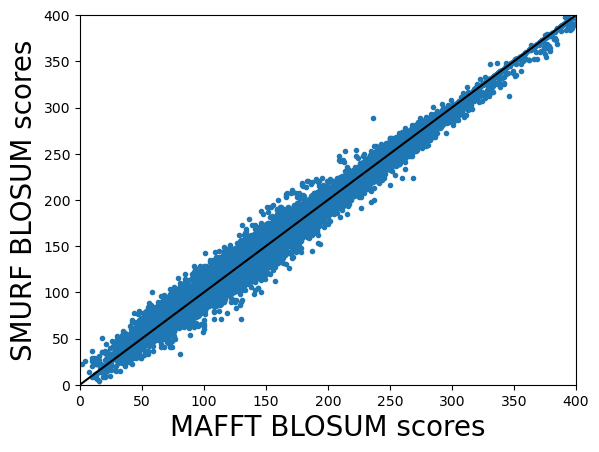

In [52]:
# num strings
N = len(msa)
blosum_SMURF = []
blosum_MAFFT = []
# get pairwise Blosum scores in order
for i in range(20):
    for j in range(i+1,N):
        blosum_SMURF.append(get_blosum_score(msa_SMURF[i],msa_SMURF[j]))
        blosum_MAFFT.append(get_blosum_score(msa_MAFFT[i],msa_MAFFT[j]))
        
plt.plot(blosum_MAFFT,blosum_SMURF,'.')
plt.plot([-50, 1000], [-50, 1000],'k')
plt.xlim([0, 400])
plt.ylim([0, 400])
plt.xlabel('MAFFT BLOSUM scores',fontsize=20)
plt.ylabel('SMURF BLOSUM scores',fontsize=20)

plt.savefig('SMURF_MAFFT_consistency.eps', dpi=400, format='eps')

In [44]:
np.average(blosum_MAFFT),np.average(blosum_SMURF)

(149.05604423221914, 148.39889419452123)